# Bias - Variance Tradeoff
In this notebook, the definition of bias and variance would be introduced. Examples of high-bias and high-variance model would be presented on Fashion MNIST dataset. Strategies to approach optimal balance such as cross validation and adding dropout layers would be introduced. 
##1. Concepts
Firstly, the concept of **Random Error** should be introduced. This error is caused by the noise of dataset itself, written as  $ϵ∼\mathcal N(0,σ_{ϵ})$. it is considered as normally distributed and irreducible. 

So if variable $y$ as label to be predicted and $X$ as arguments, we can consider the relationship as 

>> $y = f(X) + ϵ$

where $f( )$ is the pattern contained in dataset.

###What is Bias in Machine Learning
Bias reflects the difference between model's predicted values on training set and their actual values. In other words, it has negative correlation to the ability of the model to find the relevant relations between features and target outputs. High bias tend to cause underfitting, which would lead high error rate in both training and testing data.
>>$Bias = E[\hat f (X)] - f(X)$

where $\hat f( )$ is the pattern find by algorithm.
<nl>Common reasons:
* Model is too simple, incapable of capturing the corelations in dataset
* Training time is not enough
* No enough features

### What is variance in Machine Learning
Variance reflects the difference between model's prodiction and expected prediction. In other words, the stability of model's performance on different datasets (eg. training and validation dataset). Model with high variance tend to pay too much attention to training dataset, even the random noise within it. This is called overfitting and would cause model fail to generalize when facing different dataset.
>>$Var = E[(\hat f (X) - E[\hat f(X)])^2]$

Common reasons:
* Model is too complicated
* Training dataset is not large enough
* Training time too long

###Relationship between Error, Bias and Variance

For Mean Squared Error:
>> <nl> $Error(X) \\= E[(y - \hat f(X))^2] \\=E[(f(X) + ϵ - \hat f(X))^2] \\= (E(\hat f(X)) - f(x))^2 + E[(\hat f (X) - E[\hat f(X)])^2] + σ_{ϵ}^2 \\= Bias^2+Variance + Random\  Error$


![Optimal Balance](https://cdn-images-1.medium.com/max/1600/1*RQ6ICt_FBSx6mkAsGVwx8g.png)

## 2. Examples of High Bias Model and High Variance Model
###Dataset
n this part, Fashion MNIST dataset
[[Xiao et al., 2017](https://arxiv.org/abs/1708.07747)] will be used for classifying fashion
apparel images into one of ten categories:

1.  T-shirt/top
2.  Trouser
3.  Pullover
4.  Dress
5.  Coat
6.  Sandal
7.  Shirt
8.  Sneaker
9.  Bag
10. Ankle boot

![Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)

###Set up


In [2]:
#import the packages

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import functools
import os
import shutil
import tensorflow as tf
import keras
import sklearn
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [0]:
#Parameters

IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
RANDOM_SEED = 42
TEST_SIZE = 0.2

#Model
TRAIN_STEPS = 5000 # For baseline model
NO_EPOCHS = 50
BATCH_SIZE = 128

from numpy.random import seed
seed(RANDOM_SEED)
from tensorflow import set_random_seed
set_random_seed(RANDOM_SEED)  

LOG_DIR = '/tmp/models'

In [0]:
#Download the data
(X_train, y_train), (X_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data())

In [0]:
# Functions for baseline model

FEATURES_KEY = "images"

def generator(images, labels):
  """Returns a generator that returns image-label pairs."""

  def _gen():
    for image, label in zip(images, labels):
      yield image, label

  return _gen

def baseline_preprocess(image, label):
  """Preprocesses an image for the Estimator."""
  # Scale the pixel values to be between 0 and 1.
  image = image / 255.
  # Reshape the image so that we can apply a 2D convolution to it.
  image = tf.reshape(image, [28, 28, 1])
  # Features need to be supplied as a dictionary.
  features = {FEATURES_KEY: image}
  return features, label

def input_fn(partition, training, batch_size):
  """Generate an input_fn for the Estimator."""

  def _input_fn():
    if partition == "train":
      dataset = tf.data.Dataset.from_generator(
          generator(X_train, y_train), (tf.float32, tf.int32), ((28, 28), ()))
    elif partition == "predict":
      dataset = tf.data.Dataset.from_generator(
          generator(X_test[:10], y_test[:10]), (tf.float32, tf.int32), ((28,28), ()))
    else:
      dataset = tf.data.Dataset.from_generator(
          generator(X_test, y_test), (tf.float32, tf.int32), ((28, 28), ()))

    # Call repeat after shuffling, rather than before, to prevent separate
    # epochs from blending together.
    if training:
      dataset = dataset.shuffle(10 * batch_size, seed=RANDOM_SEED).repeat()
    dataset = dataset.map(baseline_preprocess).batch(batch_size)
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
    return features, labels

  return _input_fn

In [0]:
# Preprocess for keras model

def data_preprocessing(raw_X, raw_y, encoded = True):
    processed_y = raw_y
    if encoded:
      processed_y = keras.utils.to_categorical(processed_y, NUM_CLASSES)
    num_images = raw_X.shape[0]
    X_shaped_array = raw_X.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    
    #Scale the pixel values to be between 0 and 1.
    processed_X = X_shaped_array / 255
      
    return processed_X, processed_y

In [0]:
# Function for visualization

def plot_accuracy_and_loss(train_model, title = 'Training and validation error'):
    hist = train_model.history
    loss = [1-i for i in hist['acc']]
    val_loss = [1-i for i in hist['val_acc']]
    epochs = list(range(1,len(loss)+1))
    for i in range(len(loss)-1):
          plt.plot([epochs[i],epochs[i+1]], [loss[i],loss[i+1]], color='r')
          plt.scatter([epochs[i],epochs[i+1]], [loss[i],loss[i+1]], color='r')
          plt.plot([epochs[i],epochs[i+1]], [val_loss[i],val_loss[i+1]], color = 'b')
          plt.scatter([epochs[i],epochs[i+1]], [val_loss[i],val_loss[i+1]], color = 'b')
    plt.xlabel('Epochs', fontsize = 20)
    plt.ylabel('Error', fontsize = 20)
    plt.legend(['Training error', 'Validation error'], loc='upper right',fontsize = 15)
    plt.title(title, fontsize = 25)
    plt.show()

###High Bias Model
Linear model is selected as high-bias model for this dataset. Since input features are pixels, linear model would be incapbale of finding relation between  features and label effectively, so it can be considered as high-bias model

In [0]:
# Average the losses in each mini-batch when computing gradients.
loss_reduction = tf.losses.Reduction.SUM_OVER_BATCH_SIZE

# Head instance defines the loss function and metrics for `Estimators`.
head = tf.contrib.estimator.multi_class_head(
    NUM_CLASSES, loss_reduction=loss_reduction)

# For `Estimator to understand input features.
feature_columns = [
    tf.feature_column.numeric_column(FEATURES_KEY, shape=[28, 28, 1])
]

def make_config(experiment_name):
  # Estimator configuration.
  return tf.estimator.RunConfig(
    save_checkpoints_steps=1000,
    save_summary_steps=1000,
    tf_random_seed=RANDOM_SEED,
    model_dir=os.path.join(LOG_DIR, experiment_name))

estimator = tf.estimator.LinearClassifier(
    # Initialize estimator
    feature_columns=feature_columns,
    n_classes=NUM_CLASSES,
    optimizer=tf.train.AdamOptimizer,
    loss_reduction=loss_reduction,
    config=make_config("linear"))

In [0]:
results, _ = tf.estimator.train_and_evaluate(
    estimator,
    train_spec=tf.estimator.TrainSpec(
        input_fn=input_fn("train", training=True, batch_size=BATCH_SIZE),
        max_steps=TRAIN_STEPS),
    eval_spec=tf.estimator.EvalSpec(
        input_fn=input_fn("test", training=False, batch_size=BATCH_SIZE),
        steps=None,
        start_delay_secs=1,
        throttle_secs=1,  
    ))

Linear model ends up with 15.8% training error, which is much higher than 2D CNN. This is called underfitting.

In [11]:
# Print the error rate
print("Error rate:", 1-results["accuracy"])

Error rate: 0.15789997577667236


###High Variance Model
In this part, a simple 2D CNN model is used. 20% of training data is splited as validation data.

In [0]:
# preprocess the data
X_train, y_train = data_preprocessing(X_train, y_train)
X_test, y_test = data_preprocessing(X_test, y_test)

# Split the training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [0]:
def create_model1():
    # Create a 2D CNN model
    model = Sequential()
    # Add convolution 2D
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# Create the high var model
model = create_model1()

In [14]:
train_model1 = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1, shuffle = False
                  validation_data=(X_val, y_val))

48000/48000 [==============================] - 53s 1ms/step - loss: 0.0174 - acc: 0.9942 - val_loss: 0.5838 - val_acc: 0.9106
Epoch 43/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0162 - acc: 0.9944 - val_loss: 0.6315 - val_acc: 0.9095
Epoch 44/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0129 - acc: 0.9955 - val_loss: 0.6611 - val_acc: 0.9116
Epoch 45/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0175 - acc: 0.9943 - val_loss: 0.6495 - val_acc: 0.9122
Epoch 46/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0139 - acc: 0.9955 - val_loss: 0.6172 - val_acc: 0.9098
Epoch 47/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0231 - acc: 0.9929 - val_loss: 0.5997 - val_acc: 0.9078
Epoch 48/50
48000/48000 [==============================] - 53s 1ms/step - loss: 0.0115 - acc: 0.9959 - val_loss: 0.6441 - val_acc: 0.9118
Epoch 49/50
48000/48000 [=====================

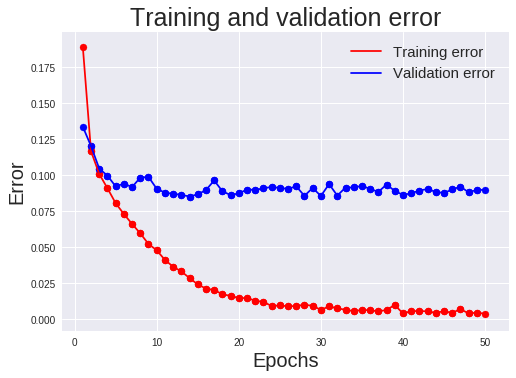

In [15]:
plot_accuracy_and_loss(train_model1)

In the plot shows above, the training error is low which indicates that this model works well in fitting training dataset. But there is a significant gap between training and validation error and validation error stops dropping since around 7th epoch. It shows that the performance of this model varies significantly when working on different dataset. It is called overfitting

##3. Approaches to optimize
The aim of model training is to make it well generalized. More specifically, to minimize the error on testing data. But in practise, testing data is not avaliable during training, so the following strategy can be used to minimize the $Error(test)$:

1. Minimize the $Error(train)$ :
 
 <nl>*Minimize bias first by finding a model which is capable of fitting the training data. Cross Validation can be used to evaluate model's performance on training data*
  
 <nl> 

2. Minimize the difference between $Error(train)$ and $Error(Validation)$

 <nl> *Once suitable model has been found, adding dropout layers and using early stopping to find proper training epochs can be used for variance reducing*


###3.1 Find a 'Better' Model with K-fold Cross Validation
####What is Cross Validation
Cross-validation(CV) is a resampling procedure used to evaluate machine learning models on a limited data sample. In k-fold CV, the general procedure is as follow:
>Step 1: Divide the original sample into K sub samples; each subsample typically has equal sample size and is referred to as one fold, altogether, K-fold.

>Step 2: In turn, while keeping one fold as a holdout sample for the purpose of Validation, perform Training on the remaining K-1 folds; one needs to repeat this step for K iterations.

>Step 3: The performance statistics (e.g., Misclassification Error) calculated from K iterations reflects the overall K-fold Cross Validation performance for a given classifier.
  
  
<nl> This technique can evaluate the performance of different model on training dataset, which could be used as a reference when selecting from a range of models. 
  
####Trade off when selecting the value of K
Selecting the value of K is a trade off between bias and variance. Since in each iteration, $\frac{k-1}{k}$ of the data would be used as training data and $\frac{1}{k}$ as testing data. When k value increases, the bias decreases since there are more training data avaliable and the trainint portion would be closer to the total dataset. Meanwhile, the data used for evaluation is getting fewer which would cause the increase of variance.
  
K=5 or 10 is considered as a balanced choice.

###Sample codes of 10-fold CV 
Aim of this 10-fold CV is to evaluate the performance of the model1 (which is shown above as high-variance model) and model2

In [0]:
def create_model2():
    # Model with fewer units in each layer
    # compare to the high-var model
    model = Sequential()
    # Add convolution 2D
    model.add(Conv2D(8, kernel_size=(3, 3),
                     activation='relu',
                     kernel_initializer='he_normal',
                     input_shape=(IMG_ROWS, IMG_COLS, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, 
                     kernel_size=(3, 3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
  
#Function for train and evaluate the model
def train_evaluate(model, X_train, y_train, X_test, y_test):
    # Number of epochs in cross validation is set as 5
    # Demonstration purpose only
    model.fit(X_train, y_train, batch_size = BATCH_SIZE,
              epochs=5, verbose = 0)
    return model.evaluate(X_test, y_test, verbose=0)

In [17]:
# Load and preprocess dataset
(X_train, y_train), (X_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data())
X_train, y_train = data_preprocessing(X_train, y_train, False)
X_test, y_test = data_preprocessing(X_test, y_test, False)

# Evaluate using 10-fold cross validation
kFold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

acc1 = []
acc2 = []

i = 1

# Use categorical label for training and evaluating model
# kFord.split only works for numerical label
y_train_categorical = keras.utils.to_categorical(y_train, NUM_CLASSES)

print("-----Training-----")
for train, test in kFold.split(X_train, y_train):
    # Only training data would be used for evaluating model's performance
    model1 = create_model1()
    
    loss, acc = train_evaluate(model1, X_train[train], y_train_categorical[train],
                               X_train[test], y_train_categorical[test])
    acc1.append(acc)
    print("Finished "+str(i)+"th evaluation for model1")
    model2 = create_model2()
    loss, acc = train_evaluate(model2, X_train[train], y_train_categorical[train],
                               X_train[test], y_train_categorical[test])
    acc2.append(acc)
    print("Finished "+str(i)+"th evaluation for model2")
    i += 1



Finished 8th evaluation for model1
Finished 8th evaluation for model2
Finished 9th evaluation for model1
Finished 9th evaluation for model2
Finished 10th evaluation for model1
Finished 10th evaluation for model2


In [18]:
print("Average accuracy of model 1 is", np.mean(acc1))
print("Average accuracy of model 2 is", np.mean(acc2))

Average accuracy of model 1 is 0.9027166666666666
Average accuracy of model 2 is 0.8720666666666667


According to the results above, the model1 has better performance and would be selected

###3.2 For High-variance Models: Add Dropout layers
In this part, the model several dropout layers are added to the model used above. The concept of dropout layer is as follow:
![Dropout Layer](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/dropout.jpeg)
<nl>Adding dropout layers is a tradeoff between training performance and generalization.
Basically during training, half of neurons on a particular layer will be deactivated. This improve generalization because it would force your layer to learn with different neurons the same "concept".
 
####Sample codes

In [0]:
def create_dropout_model():

  # Add dropout layers to model1
  
  model = Sequential()
  # Add convolution 2D
  model.add(Conv2D(32, kernel_size=(3, 3),
                   activation='relu',
                   kernel_initializer='he_normal',
                   input_shape=(IMG_ROWS, IMG_COLS, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))  #Dropout layers added
  model.add(Conv2D(64, 
                   kernel_size=(3, 3), 
                   activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.2))  #Dropout layers added
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Dropout(0.3))  #Dropout layers added
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.3))  #Dropout layers added
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])
  return model

dropout_model = create_dropout_model()

# Reload the data
(X_train, y_train), (X_test, y_test) = (
           tf.keras.datasets.fashion_mnist.load_data())
# Preprocess the data
X_train, y_train = data_preprocessing(X_train, y_train)
X_test, y_test = data_preprocessing(X_test, y_test)

# Split the training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [0]:
train_dropout_model = dropout_model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                                        epochs=NO_EPOCHS, verbose=1, 
                                        shuffle = False,
                                        validation_data=(X_val, y_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 58s 1ms/step - loss: 0.7231 - acc: 0.7301 - val_loss: 0.4507 - val_acc: 0.8357
Epoch 2/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.4706 - acc: 0.8259 - val_loss: 0.3855 - val_acc: 0.8597
Epoch 3/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.3989 - acc: 0.8529 - val_loss: 0.3359 - val_acc: 0.8761
Epoch 4/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.3592 - acc: 0.8699 - val_loss: 0.3089 - val_acc: 0.8872
Epoch 5/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.3304 - acc: 0.8781 - val_loss: 0.2907 - val_acc: 0.8936
Epoch 6/50
48000/48000 [==============================] - 54s 1ms/step - loss: 0.3141 - acc: 0.8826 - val_loss: 0.2751 - val_acc: 0.8987
Epoch 7/50
48000/48000 [==============================] - 55s 1ms/step - loss: 0.2953 - acc: 0.8919 - val_loss: 0.2643 - val_acc

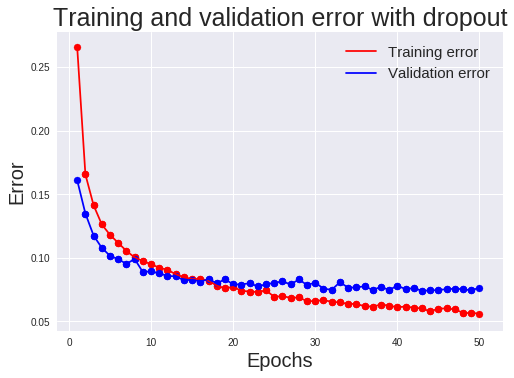

In [0]:
plot_accuracy_and_loss(train_model1, 'Training and validation error without dropout')
plot_accuracy_and_loss(train_dropout_model, 'Training and validation error with dropout')

Comparing with the two plots above, the training error with dropout is increased but the gap between validation and training error is much smaller. Overall the model with dropout is better generalized.

###3.3 Use Early Stopping to find a suitable training time
Early Stopping is a form of regularization used to avoid overfitting when training a learner with an iterative method. Once the performance of the model on validation data stop improving for a pre-defined period of time, the model would stop training to prevent overfitting.
####Sample codes

In [0]:
dropout_model = create_dropout_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=2,
                              restore_best_weights=True)

# When using early stopping, number of epochs can be larger
train_dropout_model = dropout_model.fit(X_train, y_train, batch_size=BATCH_SIZE,
                                        epochs= NO_EPOCHS * 10, verbose=1, 
                                        validation_data=(X_val,y_val), 
                                        callbacks=[early_stopping], shuffle=False)

In [0]:
plot_accuracy_and_loss(train_dropout_model, 'Training and validation error with dropout and early stopping')